In [1]:
# date: 1/7/2022
# author: Ziwen
# task: veraset - calculate device activity
import os, sys, gc
import pandas as pd
import numpy as np
import yaml
import os
import glob
import ipystata

from google.cloud import storage
from google.cloud import bigquery

path = os.path.expanduser('~')
# set up env credential variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path + '/Dropbox/Amenity/source/analysis/veraset_gravy_gps_sample/firm-exit-3608acd14b06.json'
client = bigquery.Client()

import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Device Activity
To be clear, the idea of device activity is to verify whether people move more during the day and less during the night.
1. we look at the raw ping data of devices that we were able to impute home locations
2. extract all their raw ping data
3.  
   - for all raw pings, aggregate the sum: the number of pings in an hour on a day of week for each device  
      and the distributions of pings across hours (1) weighted by the number of pings (2) all devices equally weighted  
   - for all geohash9 regions, aggregate the sum: the number of geohash9 regions in an hour on a day of week for each device  
      then do the same distributions  
     Using geohash9 (which is very small) is to look at whether people move at night. If sleep, then should be little moves  
   - redo the previous one with geohash7  
      Using geohash7 (which is much larger than geohash9) is to look at whether people basically stay at only 1 geohash7 region       at night, which should be home

In [2]:
# select, collapse to device - day of week - hour level
# for those we can identify home locations
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_device_dofw_hofd' # essentially is the data structure: device - day of week - hour
job_config_select_agg = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_select_agg = f'''
    with raw_ping as
    (select 
    -- necessary variables and calculation
        caid as caid,
        id_type as id_type,
        extract(hour from datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as hofd,
        format_datetime('%A', datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as dofw,
        substr(geo_hash, 1, 7) as geohash7,
        geo_hash as geohash9
    from `ping_ca_01`
    -- the last week excluded due to the lack of data on 10-30 and 10-31
    where cast(datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour) as datetime)<cast('2021-10-25 00:00:00' as datetime)
    ), home_raw_ping as
    (select
    -- for device we can impute their homes, select all their raw pings, at home and not at home
        raw_ping.caid as caid,
        hofd as hofd,
        dofw as dofw,
        raw_ping.geohash7 as geohash7,
        geohash9 as geohash9
    from raw_ping
    inner join `home_id_loc`
    on `home_id_loc`.`caid` = raw_ping.caid
    ), device_dofw_hofd as
    (select
        caid as caid,
        dofw as dofw,
        hofd as hofd,
        count(caid) as num_pings,
        count(distinct(concat(caid, dofw, hofd, geohash7))) as num_geohash7,
        count(distinct(concat(caid, dofw, hofd, geohash9))) as num_geohash9,
    from home_raw_ping
    -- group by device-weekday-hour level
    group by caid, dofw, hofd
    )
    select 
        *
    from device_dofw_hofd
'''

query_job_select_agg = client.query(query_select_agg, job_config=job_config_select_agg)
query_job_select_agg.result() 

In [4]:
# for reducing data size, replace mon-sun with 1-7, cast to num
# also so merge in coverage data
# for coverage, caid and id_type is not 1-1, so take the higher coverage id_type
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_device_dofw_hofd' # essentially is the data structure: device - day of week - hour
job_config_replace = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_replace = f'''
    with replace as
    -- replace mon-sun with 1-7, num
    (select
        * except (dofw),
        case 
            when (dofw = 'Monday') then 1
            when (dofw = 'Tuesday') then 2
            when (dofw = 'Wednesday') then 3
            when (dofw = 'Thursday') then 4
            when (dofw = 'Friday') then 5
            when (dofw = 'Saturday') then 6
            when (dofw = 'Sunday') then 7
        end
        as dofw
    from `home_device_dofw_hofd`
    )
    select 
        replace.*,
        `monthly_coverage`.coverage_1
    from replace
    inner join `monthly_coverage`
    on `monthly_coverage`.`caid` = replace.caid
'''

query_job_replace = client.query(query_replace, job_config=job_config_replace)
query_job_replace.result() 

In [8]:
# down sample
default_dataset = 'firm-exit.veraset_visits'
job_config_downsample = bigquery.QueryJobConfig(default_dataset=default_dataset)

query_downsample = f'''
    with caid_num as
    -- generate numerical id for caid
    (select
        caid as caid,
        row_number() over () as device_id
    from `home_id_loc`
    ), id_replace as
    -- replace string id with num id, easier to process
    (select
        `home_device_dofw_hofd`.`hofd`,
        `home_device_dofw_hofd`.`num_pings`,
        `home_device_dofw_hofd`.`num_geohash7`,
        `home_device_dofw_hofd`.`num_geohash9`,
        `home_device_dofw_hofd`.`dofw`,
        `home_device_dofw_hofd`.`coverage_1`,
        caid_num.device_id
    from `home_device_dofw_hofd`
    inner join caid_num
    on `home_device_dofw_hofd`.`caid` = caid_num.caid
    )
    select 
        *,
    from id_replace
    order by device_id
    limit 20000000
'''

query_job_downsample = client.query(query_downsample, job_config=job_config_downsample)
query_job_downsample.result() 


In [9]:
downsample = query_job_downsample.to_dataframe()
downsample.to_csv(path+'/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/home_device_dofw_hofd_sample.csv', sep=',', mode='w')

## Summary plots
the data has several key variables of interets:  
1. device_id (equiv. to caid),  
2. dofw (day of week: Monday - Sunday 1-7),  
3. hofd (hour of day),  
4. num_pings (the number of pings in that hour on that day),  
5. num_geohash7 (the number of unique geohash7 regions the device has been to in that hour on that day),  
6. num_geohash9 (the number of unique geohash9 regions the device has been to in that hour on that day),  
7. coverage (GPS coverage of that device): 25%: 0.00056; 50%: 0.0020161; 75%: .0080869    

Plot the following to understand the distribution of variable 4,5,6  
1. for the number of pings on each day of week (1-7), make a box plot summarizing the distribution of the number of pings across 24 hours on that day. Do it with the entire sample, and with 4 different coverage batches. (7*5=35 graphs)
2. for the number of pings on each day of week (1-7), first calculate the total number of pings in an hour across all devices, then divide that by the total number of pings across all devices on that entire day. Make a bar plot summarizing the shares. This is called ``weighted by # of pings``. Do it with the entire sample, and with 4 different coverage batches. (35 graphs)
3. for the number of pings on each day of week (1-7), first calculate the share of pings in each hour of the day for every single device (now for every device you have 24 numbers that add up to 1), then make a box plot summarizing the distribution of such shares in each hour across all devices. Do it with the entire sample, and with 4 different coverage batches. (7*5=35 graphs)

Then do the same thing for number of geohash7 and geohash9. Tedious but worth looking at.

Then do it with the entire sample, aka do not do it for each day of week, aggregate at hour level. And then separately, aggregate at day of week level. With different coverage batches.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [19]:
# read the data and define coverage batches
df = pd.read_csv(path+'/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/home_device_dofw_hofd_sample.csv')
df = df.iloc[:,1:]
df['coverage_group'] = (df['coverage_1'] > 0.00056).astype(int) + (df['coverage_1'] > 0.0020161).astype(int) + (df['coverage_1'] > 0.0080869).astype(int)
df.head()

,hofd,num_pings,num_geohash7,num_geohash9,dofw,coverage_1,device_id,coverage_group
0,18,112,1,4,6,0.009008,1,3
1,18,57,1,2,5,0.009008,1,3
2,10,4,1,2,6,0.009008,1,3
3,19,27,1,2,6,0.009008,1,3
4,13,4,1,2,1,0.009008,1,3


In [20]:
df['lg_num_pings'] = np.log(df['num_pings'])
df['lg_num_geohash7'] = np.log(df['num_geohash7'])
df['lg_num_geohash9'] = np.log(df['num_geohash9'])

In [21]:
# split the data
df_coverage_1 = df[df['coverage_group'] == 3]
df_coverage_2 = df[df['coverage_group'] == 2]
df_coverage_3 = df[df['coverage_group'] == 1]
df_coverage_4 = df[df['coverage_group'] == 0]

In [22]:
# aggregate at hour level
agg_dict_hour = {'num_pings':'sum', 'num_geohash7':'sum', 'num_geohash9':'sum', 'lg_num_pings':'sum', 'lg_num_geohash7':'sum', 'lg_num_geohash9':'sum'}
df_hour = df.groupby(['hofd', 'device_id']).aggregate(agg_dict_hour).reset_index()
df_hour_coverage_1 = df_coverage_1.groupby(['hofd', 'device_id']).aggregate(agg_dict_hour).reset_index()
df_hour_coverage_2 = df_coverage_2.groupby(['hofd', 'device_id']).aggregate(agg_dict_hour).reset_index()
df_hour_coverage_3 = df_coverage_3.groupby(['hofd', 'device_id']).aggregate(agg_dict_hour).reset_index()
df_hour_coverage_4 = df_coverage_4.groupby(['hofd', 'device_id']).aggregate(agg_dict_hour).reset_index()
df_hour.head()

,hofd,device_id,num_pings,num_geohash7,num_geohash9,lg_num_pings,lg_num_geohash7,lg_num_geohash9
0,0,1,15,1,1,2.708050,0.000000,0.000000
1,0,3,73,5,8,9.075208,0.693147,2.484907
2,0,4,2,1,2,0.693147,0.000000,0.693147
3,0,9,8,2,2,2.079442,0.693147,0.693147
4,0,14,54,4,5,10.258080,0.000000,0.693147


In [23]:
# aggregate at day of week level
agg_dict_day = {'num_pings':'sum', 'num_geohash7':'sum', 'num_geohash9':'sum', 'lg_num_pings':'sum', 'lg_num_geohash7':'sum', 'lg_num_geohash9':'sum'}
df_day = df.groupby(['dofw', 'device_id']).aggregate(agg_dict_day).reset_index()
df_day_coverage_1 = df_coverage_1.groupby(['dofw', 'device_id']).aggregate(agg_dict_day).reset_index()
df_day_coverage_2 = df_coverage_2.groupby(['dofw', 'device_id']).aggregate(agg_dict_day).reset_index()
df_day_coverage_3 = df_coverage_3.groupby(['dofw', 'device_id']).aggregate(agg_dict_day).reset_index()
df_day_coverage_4 = df_coverage_4.groupby(['dofw', 'device_id']).aggregate(agg_dict_day).reset_index()
df_day.head()

,dofw,device_id,num_pings,num_geohash7,num_geohash9,lg_num_pings,lg_num_geohash7,lg_num_geohash9
0,1,1,195,38,53,17.978784,4.905275,7.742402
1,1,2,86,1,1,4.454347,0.000000,0.000000
2,1,3,81,7,11,12.978844,0.693147,3.178054
3,1,4,19,3,3,3.806662,0.000000,0.000000
4,1,5,43,8,8,8.571681,2.079442,2.079442


In [24]:
# box plot of variables of interests
def box_plot(data, x, y, xlabel, ylabel):
  fig, axs = plt.subplots(1,5, figsize=(30,4))
  fig.subplots_adjust(wspace=2)
  sns.boxplot(x=x, y=y, ax=axs[0], data=eval(data))
  axs[0].set_xlabel(xlabel)
  axs[0].set_ylabel("%s - All Devices" % ylabel)
  sns.boxplot(x=x, y=y, ax=axs[1], data=eval("{}_coverage_1".format(data)))
  axs[1].set_xlabel(xlabel)
  axs[1].set_ylabel("%s - High Coverage" % ylabel)
  sns.boxplot(x=x, y=y, ax=axs[2], data=eval("{}_coverage_2".format(data)))
  axs[2].set_xlabel(xlabel)
  axs[2].set_ylabel("%s - Mid - High Coverage" % ylabel)
  sns.boxplot(x=x, y=y, ax=axs[3], data=eval("{}_coverage_3".format(data)))
  axs[3].set_xlabel(xlabel)
  axs[3].set_ylabel("%s - Mid - Low Coverage" % ylabel)
  sns.boxplot(x=x, y=y, ax=axs[4], data=eval("{}_coverage_4".format(data)))
  axs[4].set_xlabel(xlabel)
  axs[4].set_ylabel("%s - Low Coverage" % ylabel)
  plt.tight_layout()
  plt.show()

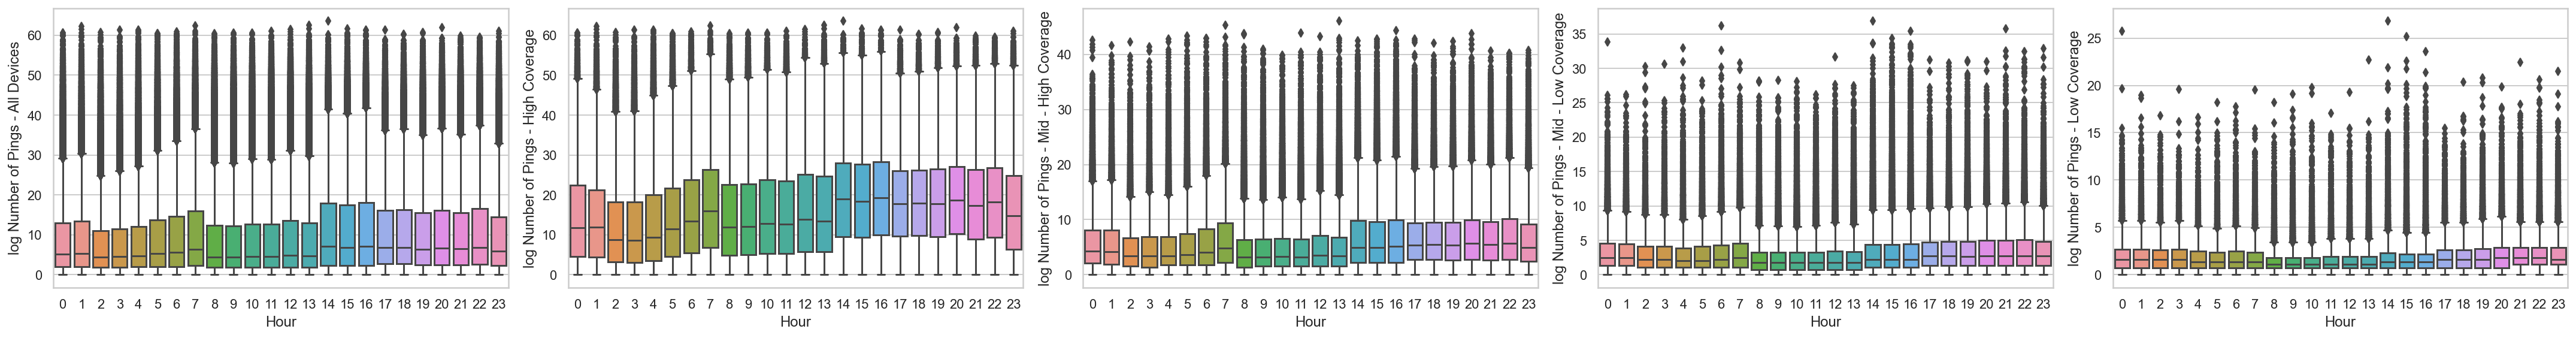

In [25]:
# box plot of number of pings, aggregate at hour level
box_plot('df_hour', 'hofd', 'lg_num_pings', 'Hour', 'log Number of Pings')

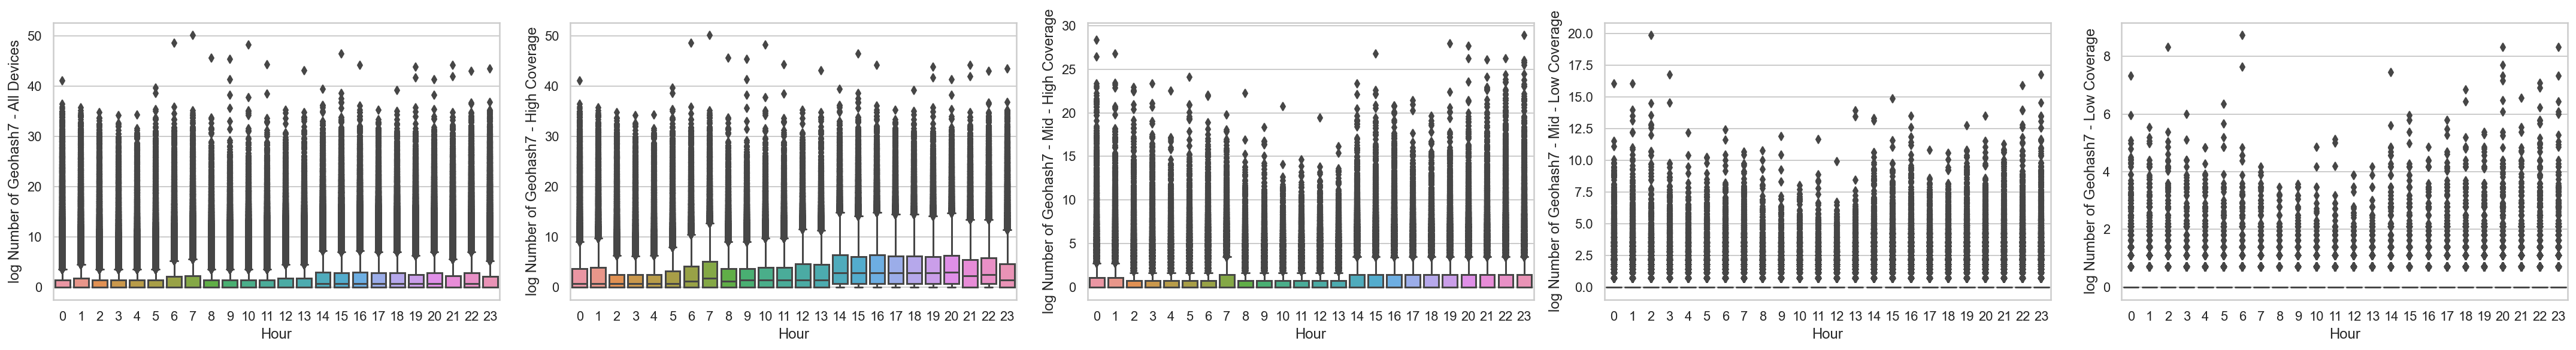

In [26]:
# box plot of number of geohash7, aggregate at hour level
box_plot('df_hour', 'hofd', 'lg_num_geohash7', 'Hour', 'log Number of Geohash7')

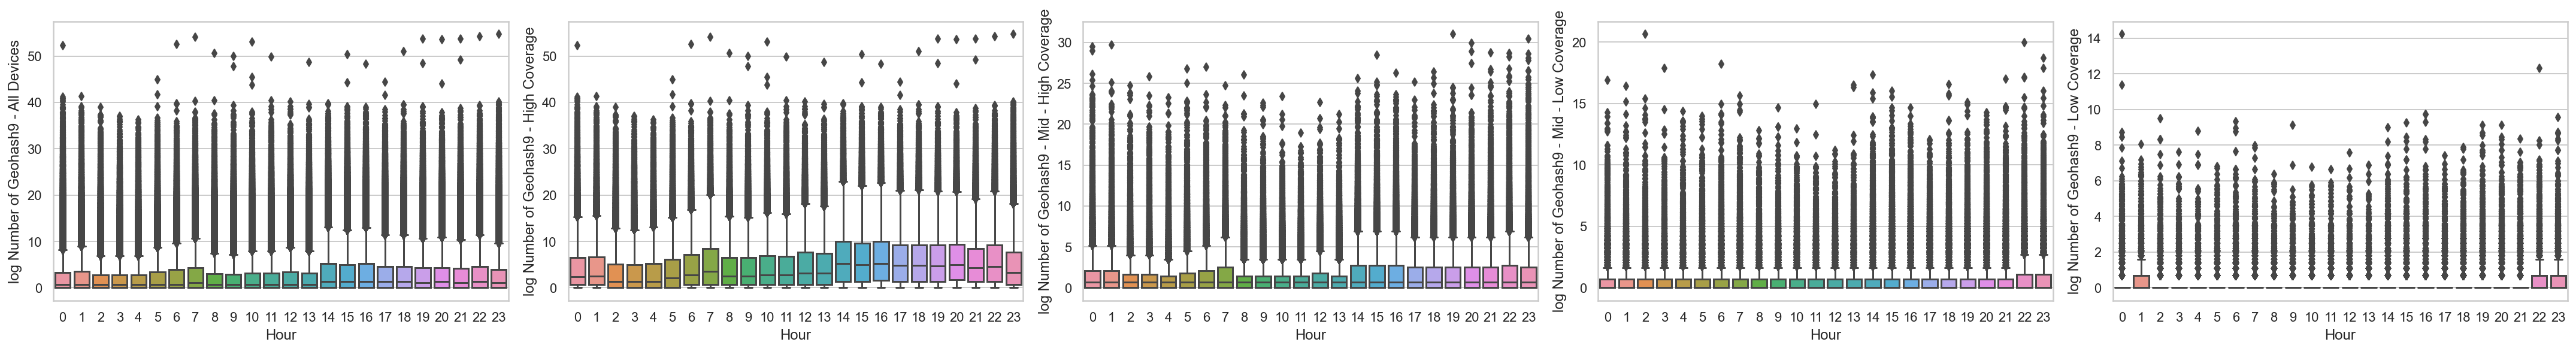

In [27]:
# box plot of number of geohash9, aggregate at hour level
box_plot('df_hour', 'hofd', 'lg_num_geohash9', 'Hour', 'log Number of Geohash9')

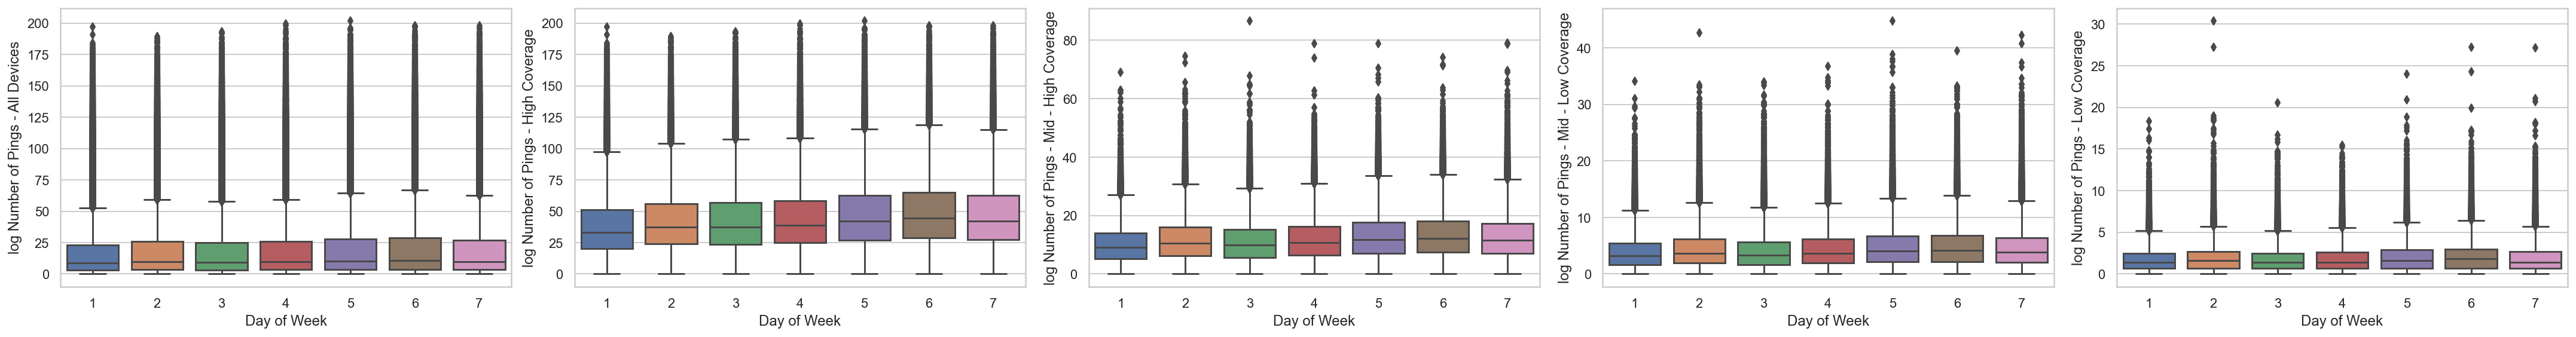

In [28]:
# box plot of number of pings, aggregate at day of week level
box_plot('df_day', 'dofw', 'lg_num_pings', 'Day of Week', 'log Number of Pings')

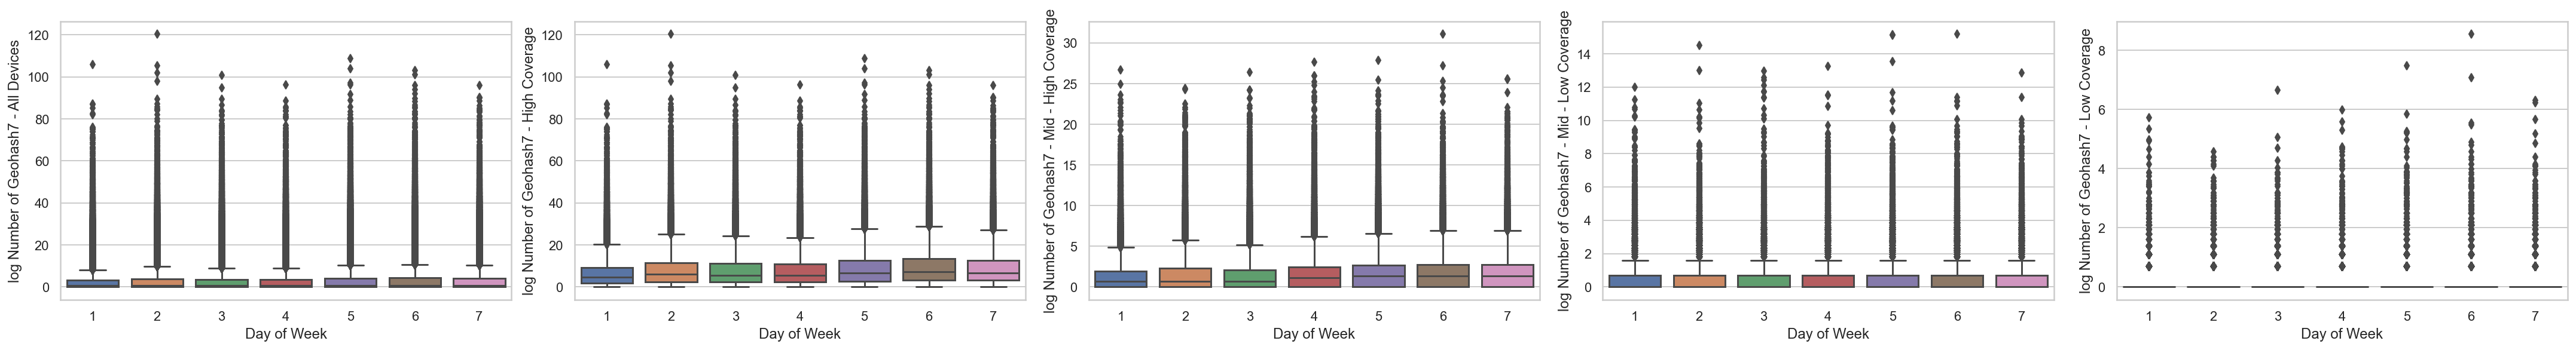

In [29]:
# box plot of number of geohash7, aggregate at day of week level
box_plot('df_day', 'dofw', 'lg_num_geohash7', 'Day of Week', 'log Number of Geohash7')

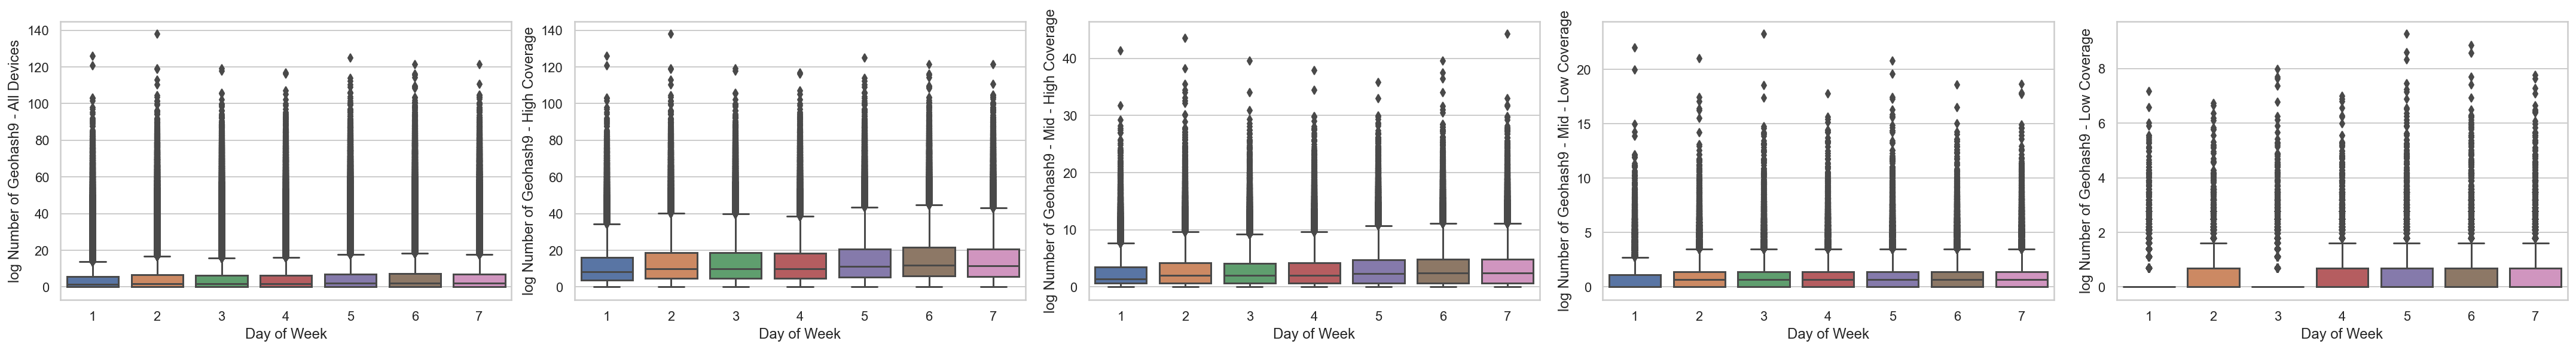

In [30]:
# box plot of number of geohash9, aggregate at day of week level
box_plot('df_day', 'dofw', 'lg_num_geohash9', 'Day of Week', 'log Number of Geohash9')

In [31]:
# aggregate at hour level, all devices
agg_dict_hour = {'num_pings':'sum', 'num_geohash7':'sum', 'num_geohash9':'sum', 'lg_num_pings':'sum', 'lg_num_geohash7':'sum', 'lg_num_geohash9':'sum'}
col_regular_hour = ['num_pings', 'num_geohash7', 'num_geohash9', 'lg_num_pings', 'lg_num_geohash7', 'lg_num_geohash9']
df_hour_all_device = df.groupby(['hofd']).aggregate(agg_dict_hour).reset_index()
df_hour_all_device_coverage_1 = df_coverage_1.groupby(['hofd']).aggregate(agg_dict_hour).reset_index()
df_hour_all_device_coverage_2 = df_coverage_2.groupby(['hofd']).aggregate(agg_dict_hour).reset_index()
df_hour_all_device_coverage_3 = df_coverage_3.groupby(['hofd']).aggregate(agg_dict_hour).reset_index()
df_hour_all_device_coverage_4 = df_coverage_4.groupby(['hofd']).aggregate(agg_dict_hour).reset_index()
df_hour_all_device[col_regular_hour] = df_hour_all_device[col_regular_hour].apply(lambda x: x/np.sum(x))
df_hour_all_device_coverage_1[col_regular_hour] = df_hour_all_device_coverage_1[col_regular_hour].apply(lambda x: x/np.sum(x))
df_hour_all_device_coverage_2[col_regular_hour] = df_hour_all_device_coverage_2[col_regular_hour].apply(lambda x: x/np.sum(x))
df_hour_all_device_coverage_3[col_regular_hour] = df_hour_all_device_coverage_3[col_regular_hour].apply(lambda x: x/np.sum(x))
df_hour_all_device_coverage_4[col_regular_hour] = df_hour_all_device_coverage_4[col_regular_hour].apply(lambda x: x/np.sum(x))
df_hour_all_device.head()

,hofd,num_pings,num_geohash7,num_geohash9,lg_num_pings,lg_num_geohash7,lg_num_geohash9
0,0,0.032114,0.033458,0.033030,0.029365,0.028260,0.028974
1,1,0.025197,0.029346,0.028665,0.026041,0.026044,0.026596
2,2,0.019266,0.020760,0.020609,0.018866,0.017068,0.018548
3,3,0.017552,0.018085,0.018312,0.017382,0.015081,0.016918
4,4,0.021366,0.017026,0.017457,0.018619,0.014614,0.016886


In [32]:
# aggregate at day of week level, all devices
agg_dict_day = {'num_pings':'sum', 'num_geohash7':'sum', 'num_geohash9':'sum', 'lg_num_pings':'sum', 'lg_num_geohash7':'sum', 'lg_num_geohash9':'sum'}
col_regular_day = ['num_pings', 'num_geohash7', 'num_geohash9', 'lg_num_pings', 'lg_num_geohash7', 'lg_num_geohash9']
df_day_all_device = df.groupby(['dofw']).aggregate(agg_dict_hour).reset_index()
df_day_all_device_coverage_1 = df_coverage_1.groupby(['dofw']).aggregate(agg_dict_hour).reset_index()
df_day_all_device_coverage_2 = df_coverage_2.groupby(['dofw']).aggregate(agg_dict_hour).reset_index()
df_day_all_device_coverage_3 = df_coverage_3.groupby(['dofw']).aggregate(agg_dict_hour).reset_index()
df_day_all_device_coverage_4 = df_coverage_4.groupby(['dofw']).aggregate(agg_dict_hour).reset_index()
df_day_all_device[col_regular_day] = df_day_all_device[col_regular_day].apply(lambda x: x/np.sum(x))
df_day_all_device_coverage_1[col_regular_day] = df_day_all_device_coverage_1[col_regular_day].apply(lambda x: x/np.sum(x))
df_day_all_device_coverage_2[col_regular_day] = df_day_all_device_coverage_2[col_regular_day].apply(lambda x: x/np.sum(x))
df_day_all_device_coverage_3[col_regular_day] = df_day_all_device_coverage_3[col_regular_day].apply(lambda x: x/np.sum(x))
df_day_all_device_coverage_4[col_regular_day] = df_day_all_device_coverage_4[col_regular_day].apply(lambda x: x/np.sum(x))
df_day_all_device.head()

,dofw,num_pings,num_geohash7,num_geohash9,lg_num_pings,lg_num_geohash7,lg_num_geohash9
0,1,0.109087,0.116846,0.114352,0.120749,0.112927,0.116435
1,2,0.123038,0.139304,0.139032,0.136049,0.139389,0.138860
2,3,0.127489,0.138136,0.137967,0.135395,0.136205,0.137200
3,4,0.149144,0.137781,0.136668,0.141231,0.135879,0.137358
4,5,0.157997,0.152548,0.153891,0.152939,0.155287,0.153589


In [33]:
# bar plot of variables of interests
def bar_plot(data, x, y, xlabel, ylabel):
  fig, axs = plt.subplots(1,5, figsize=(30,4))
  fig.subplots_adjust(wspace=0.15)
  axs[0].bar(x, y, data = eval(data))
  axs[0].set_xlabel(xlabel)
  axs[0].set_ylabel("%s - All Devices" % ylabel)
  axs[1].bar(x, y, data=eval("{}_coverage_1".format(data)))
  axs[1].set_xlabel(xlabel)
  axs[1].set_ylabel("%s - High Coverage" % ylabel)
  axs[2].bar(x, y, data=eval("{}_coverage_2".format(data)))
  axs[2].set_xlabel(xlabel)
  axs[2].set_ylabel("%s - Mid - High Coverage" % ylabel)
  axs[3].bar(x, y, data=eval("{}_coverage_3".format(data)))
  axs[3].set_xlabel(xlabel)
  axs[3].set_ylabel("%s - Mid - Low Coverage" % ylabel)
  axs[4].bar(x, y, data=eval("{}_coverage_4".format(data)))
  axs[4].set_xlabel(xlabel)
  axs[4].set_ylabel("%s - Low Coverage" % ylabel)
  plt.tight_layout()
  plt.show()

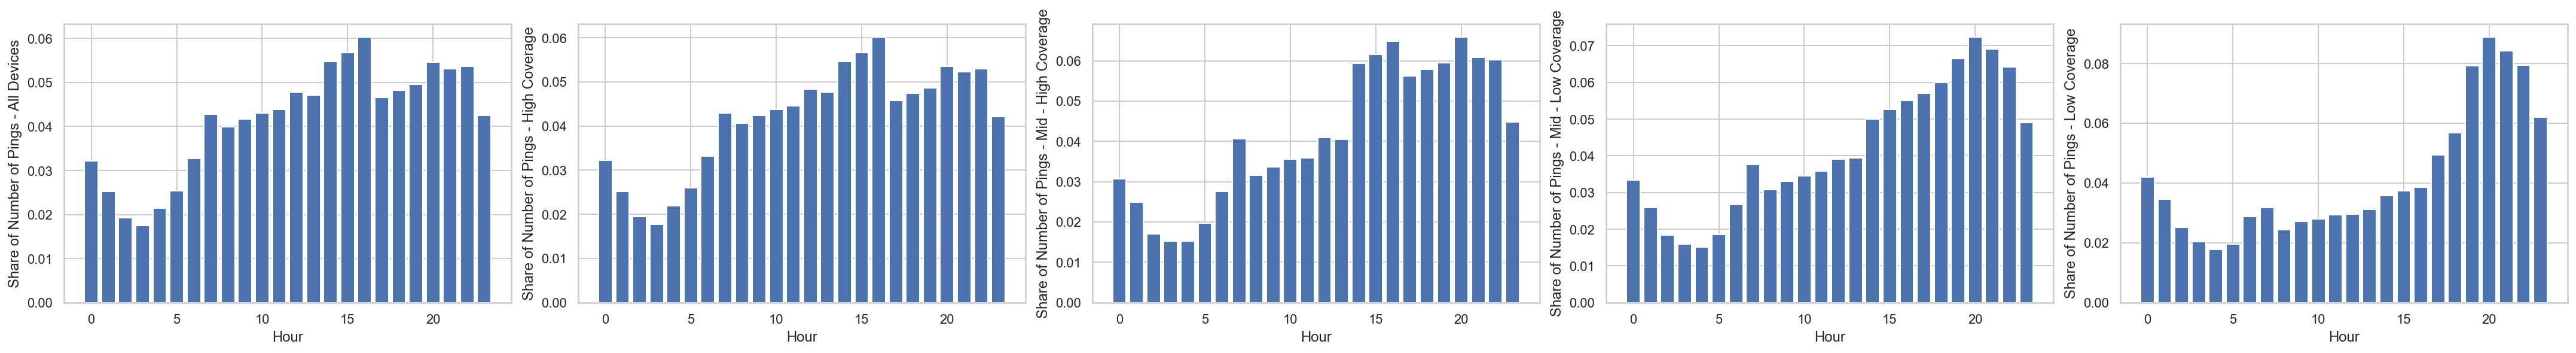

In [34]:
# bar plot of number of pings, aggregate at hour level
bar_plot('df_hour_all_device', 'hofd', 'num_pings', 'Hour', 'Share of Number of Pings')

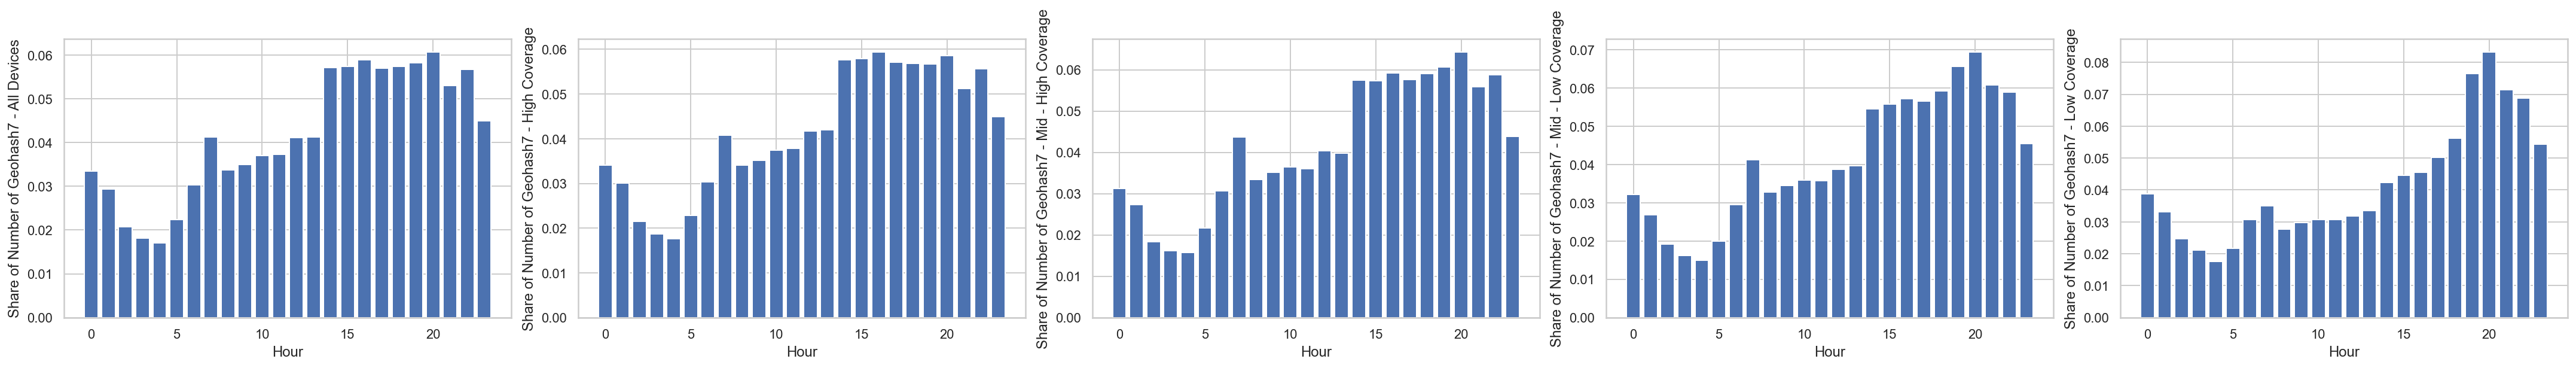

In [35]:
# bar plot of number of Geohash7, aggregate at hour level
bar_plot('df_hour_all_device', 'hofd', 'num_geohash7', 'Hour', 'Share of Number of Geohash7')

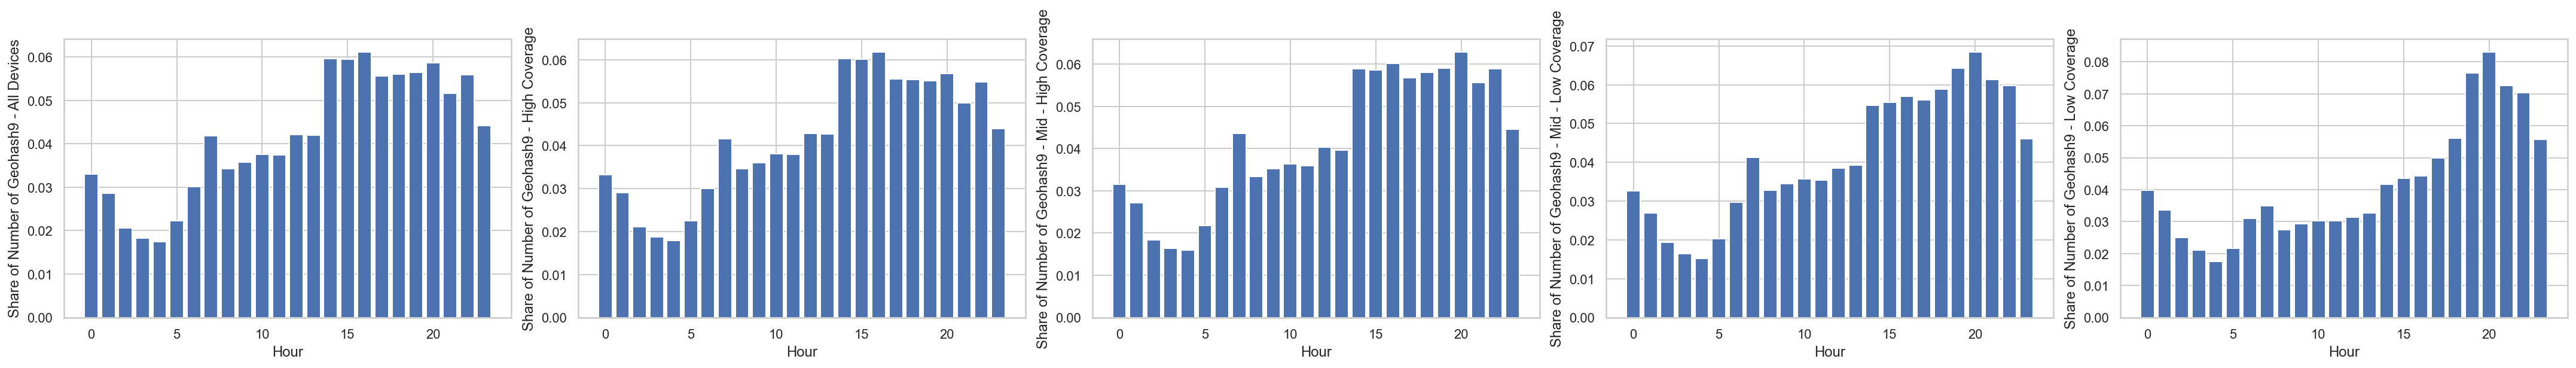

In [36]:
# bar plot of number of Geohash9, aggregate at hour level
bar_plot('df_hour_all_device', 'hofd', 'num_geohash9', 'Hour', 'Share of Number of Geohash9')

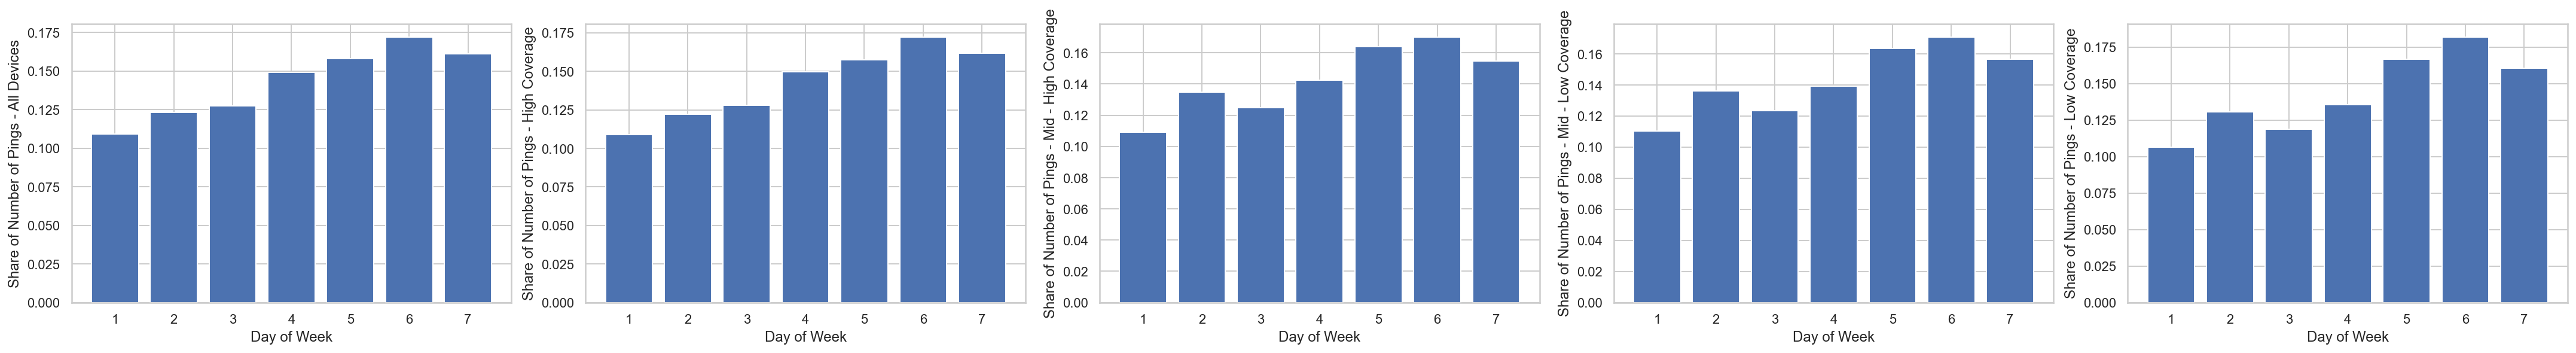

In [37]:
# bar plot of number of pings, aggregate at day of week level
bar_plot('df_day_all_device', 'dofw', 'num_pings', 'Day of Week', 'Share of Number of Pings')

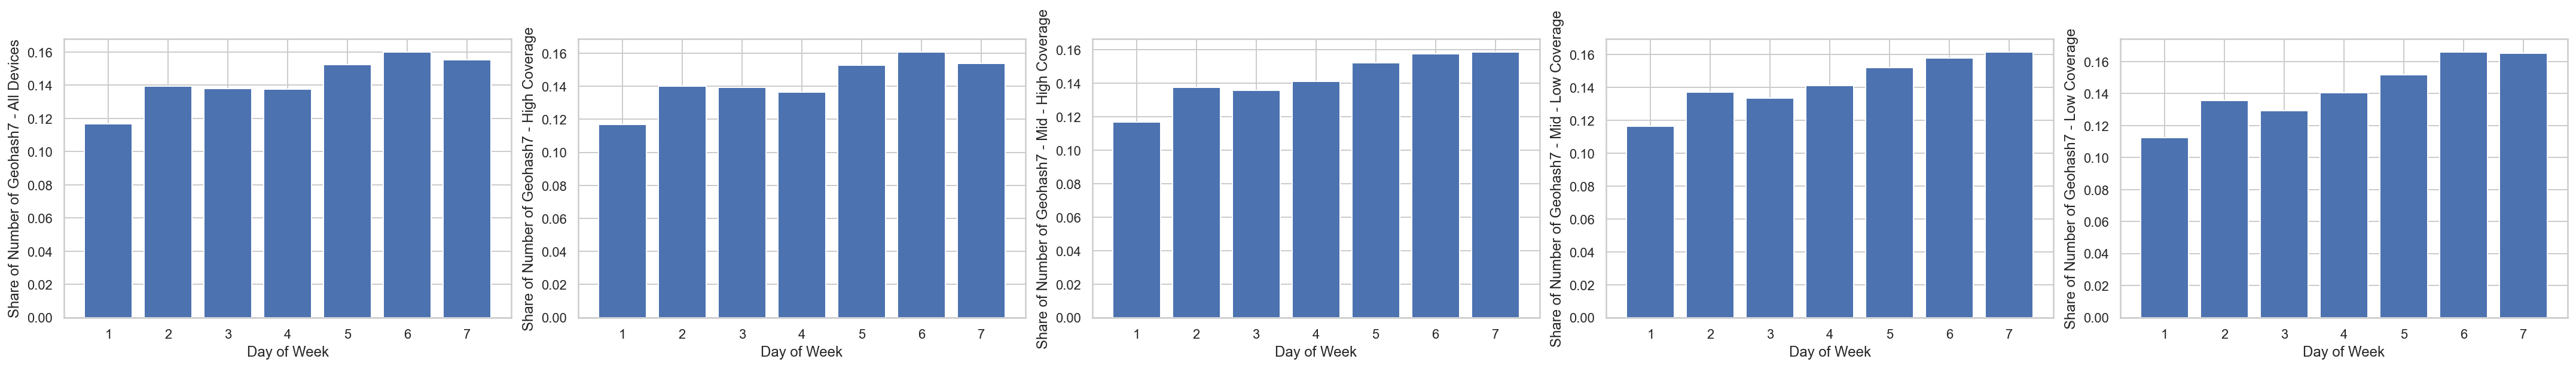

In [38]:
# bar plot of number of geohash7, aggregate at day of week level
bar_plot('df_day_all_device', 'dofw', 'num_geohash7', 'Day of Week', 'Share of Number of Geohash7')

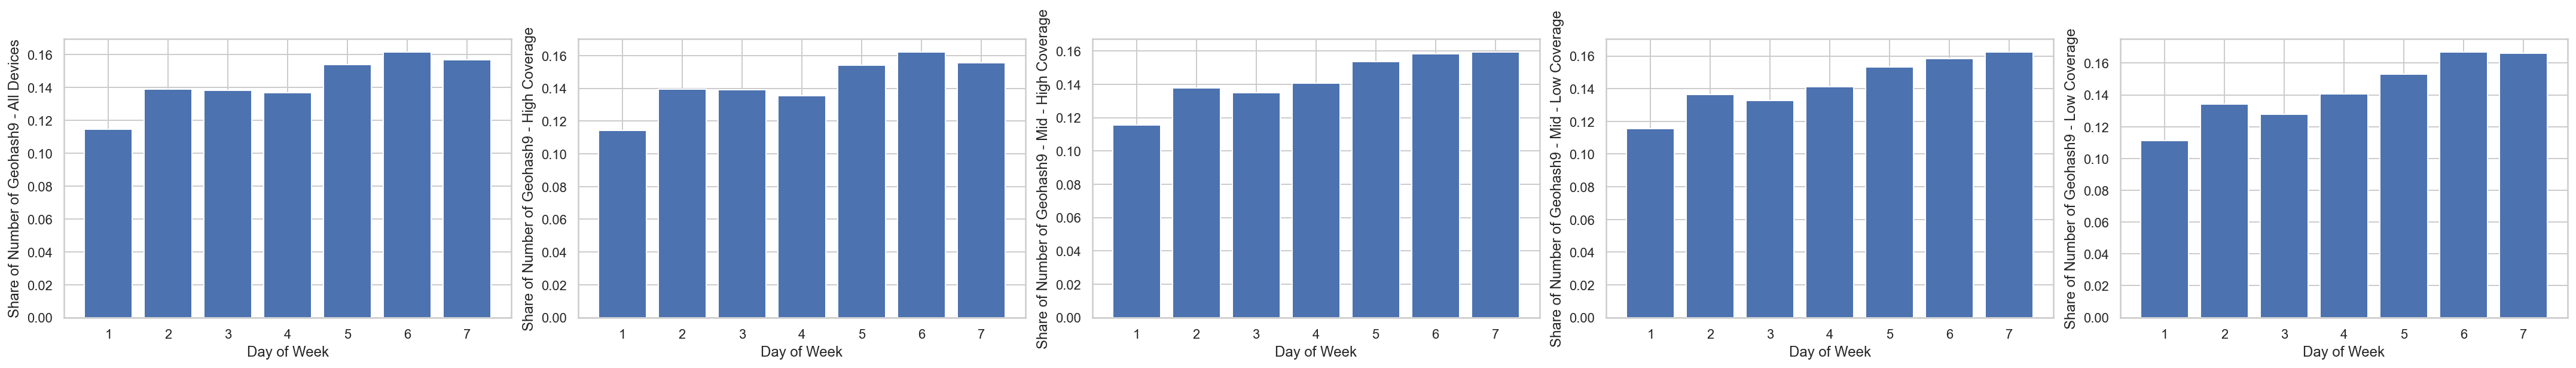

In [39]:
# bar plot of number of geohash9, aggregate at day of week level
bar_plot('df_day_all_device', 'dofw', 'num_geohash9', 'Day of Week', 'Share of Number of Geohash9')

In [40]:
# aggregate for every single devices
agg_dict = {'num_pings':'sum', 'num_geohash7':'sum', 'num_geohash9':'sum'}
col_regular = ['num_pings', 'num_geohash7', 'num_geohash9']
col_sum = ['sum_num_pings', 'sum_num_geohash7', 'sum_num_geohash9']


def agg_every_device(data, level):
    data_every_device = data.groupby(['device_id', level]).aggregate(agg_dict).reset_index()
    sum_every_device = data.groupby(['device_id']).aggregate(agg_dict).reset_index()
    sum_every_device.columns = ['device_id'] + col_sum
    data_every_device = pd.merge(data_every_device, sum_every_device, on='device_id')
    data_every_device['num_pings'] = data_every_device['num_pings']/data_every_device['sum_num_pings']
    data_every_device['num_geohash7'] = data_every_device['num_geohash7']/data_every_device['sum_num_geohash7']
    data_every_device['num_geohash9'] = data_every_device['num_geohash9']/data_every_device['sum_num_geohash9']
    return data_every_device

In [41]:
# aggregate at hour level, every single devices
df_hour_every_device = agg_every_device(df, 'hofd')
df_hour_every_device_coverage_1 = agg_every_device(df_coverage_1, 'hofd')
df_hour_every_device_coverage_2 = agg_every_device(df_coverage_2, 'hofd')
df_hour_every_device_coverage_3 = agg_every_device(df_coverage_3, 'hofd')
df_hour_every_device_coverage_4 = agg_every_device(df_coverage_4, 'hofd')
df_hour_every_device.head()

,device_id,hofd,num_pings,num_geohash7,num_geohash9,sum_num_pings,sum_num_geohash7,sum_num_geohash9
0,1,0,0.014764,0.006579,0.004831,1016,152,207
1,1,1,0.003937,0.019737,0.014493,1016,152,207
2,1,2,0.007874,0.039474,0.028986,1016,152,207
3,1,6,0.162402,0.046053,0.062802,1016,152,207
4,1,7,0.143701,0.052632,0.072464,1016,152,207


In [42]:
# aggregate at day of week level, every single devices
df_day_every_device = agg_every_device(df, 'dofw')
df_day_every_device_coverage_1 = agg_every_device(df_coverage_1, 'dofw')
df_day_every_device_coverage_2 = agg_every_device(df_coverage_2, 'dofw')
df_day_every_device_coverage_3 = agg_every_device(df_coverage_3, 'dofw')
df_day_every_device_coverage_4 = agg_every_device(df_coverage_4, 'dofw')
df_day_every_device.head()

,device_id,dofw,num_pings,num_geohash7,num_geohash9,sum_num_pings,sum_num_geohash7,sum_num_geohash9
0,1,1,0.191929,0.250000,0.256039,1016,152,207
1,1,2,0.055118,0.144737,0.144928,1016,152,207
2,1,3,0.038386,0.065789,0.057971,1016,152,207
3,1,4,0.119094,0.059211,0.057971,1016,152,207
4,1,5,0.281496,0.171053,0.173913,1016,152,207


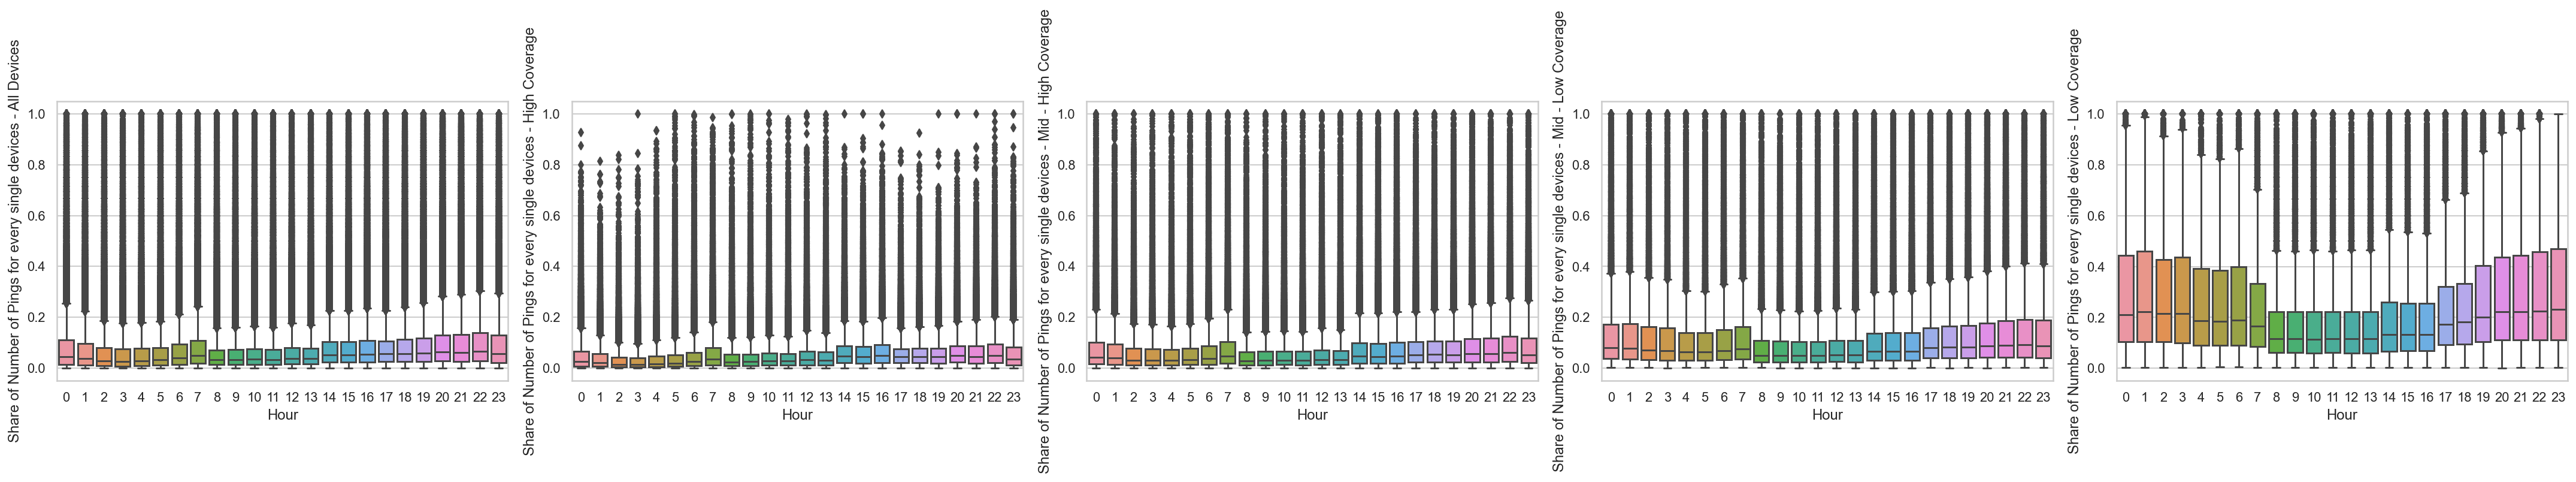

In [43]:
# box plot of share of number of pings for every single devices, aggregate at hour level
box_plot('df_hour_every_device', 'hofd', 'num_pings', 'Hour', 'Share of Number of Pings for every single devices')

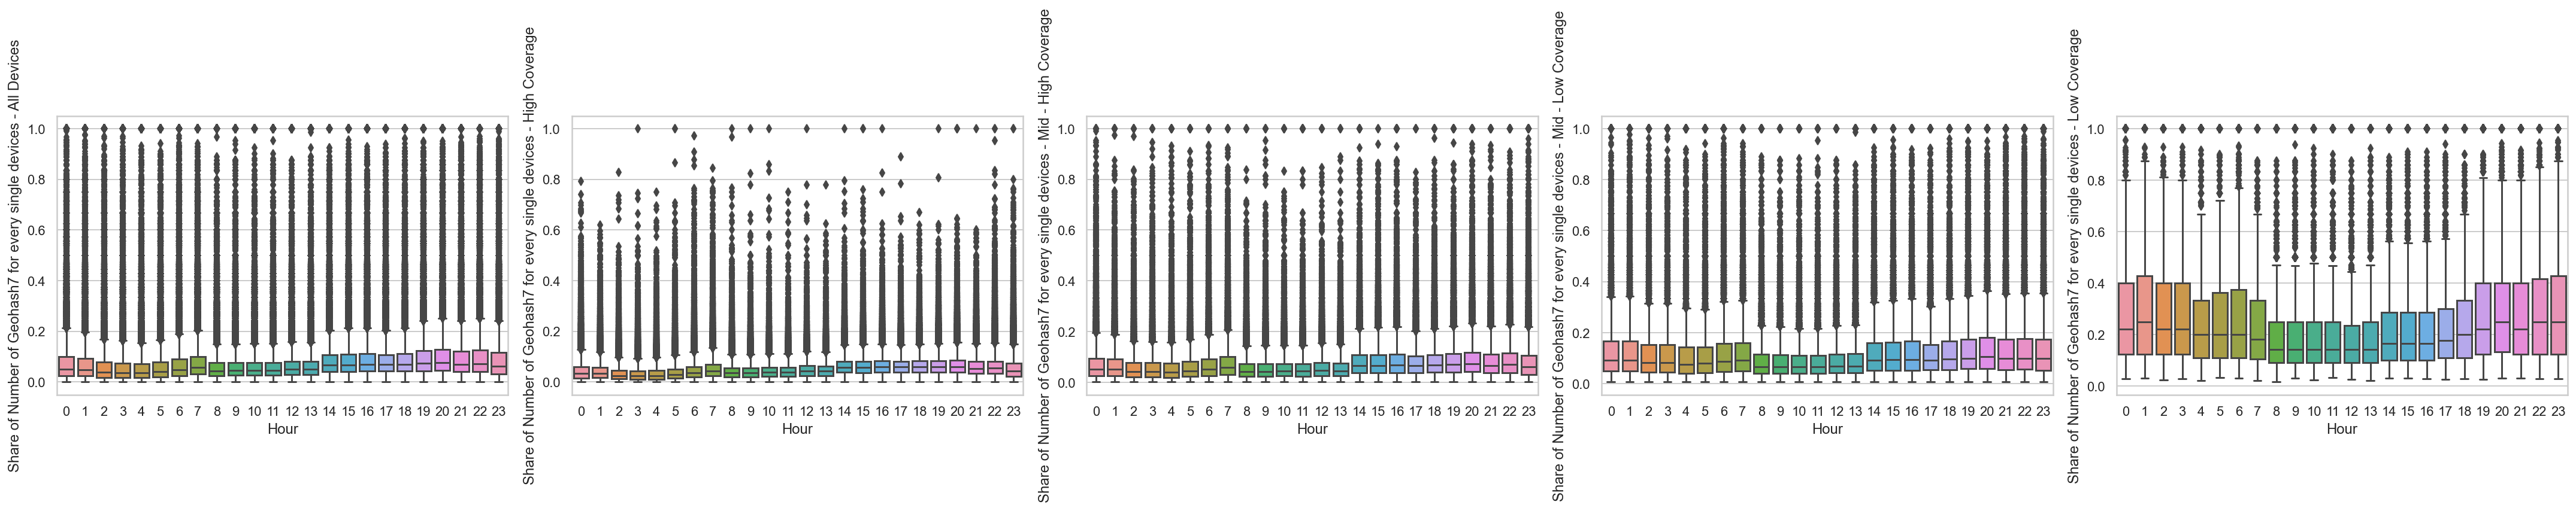

In [44]:
# box plot of share of number of geohash7 for every single devices, aggregate at hour level
box_plot('df_hour_every_device', 'hofd', 'num_geohash7', 'Hour', 'Share of Number of Geohash7 for every single devices')

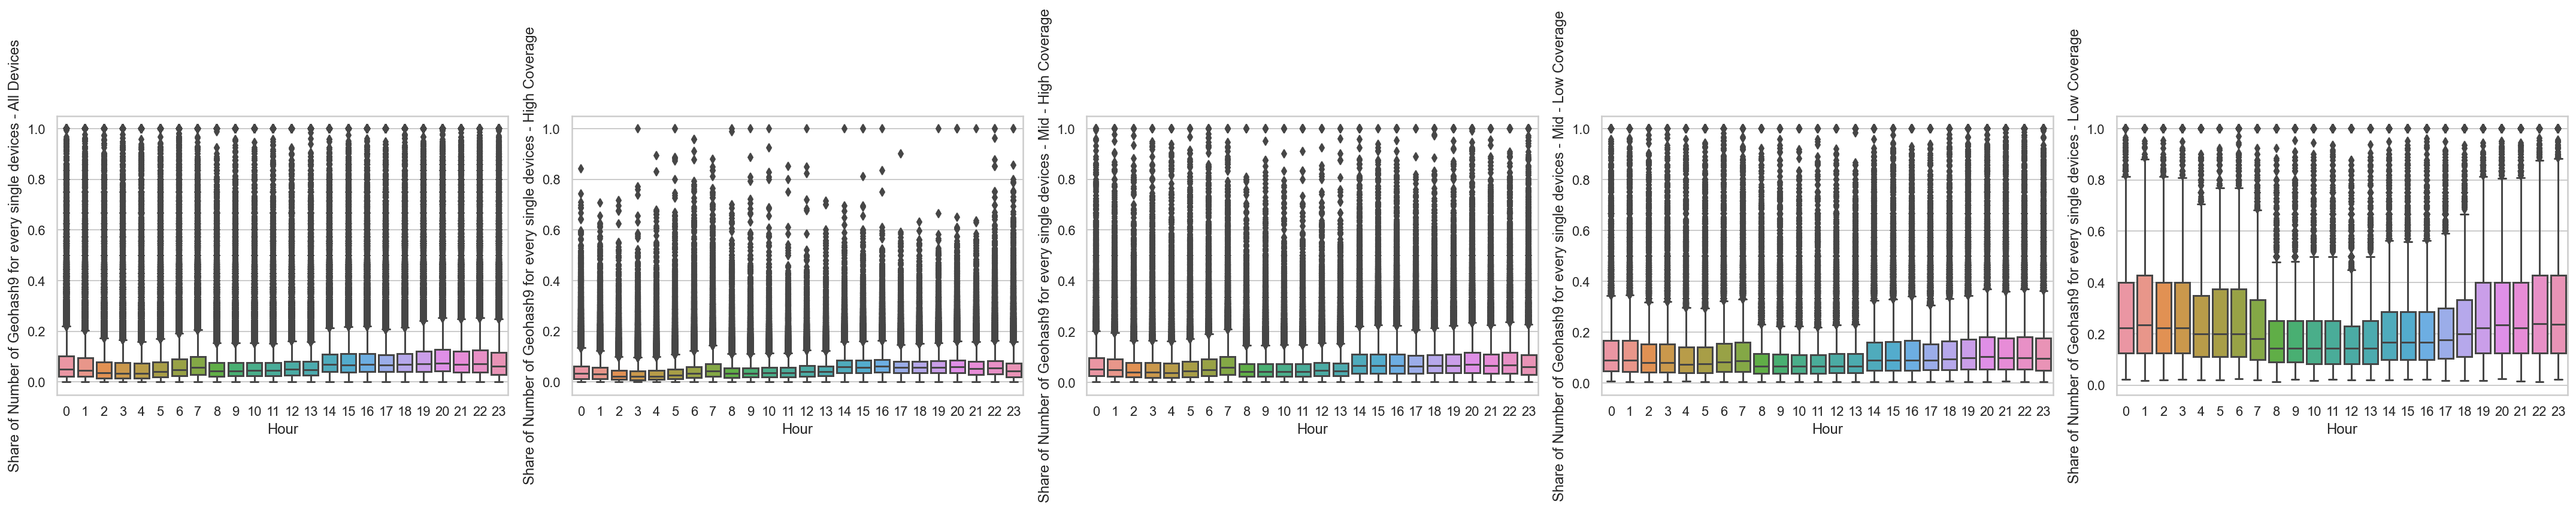

In [45]:
# box plot of share of number of geohash9 for every single devices, aggregate at hour level
box_plot('df_hour_every_device', 'hofd', 'num_geohash9', 'Hour', 'Share of Number of Geohash9 for every single devices')

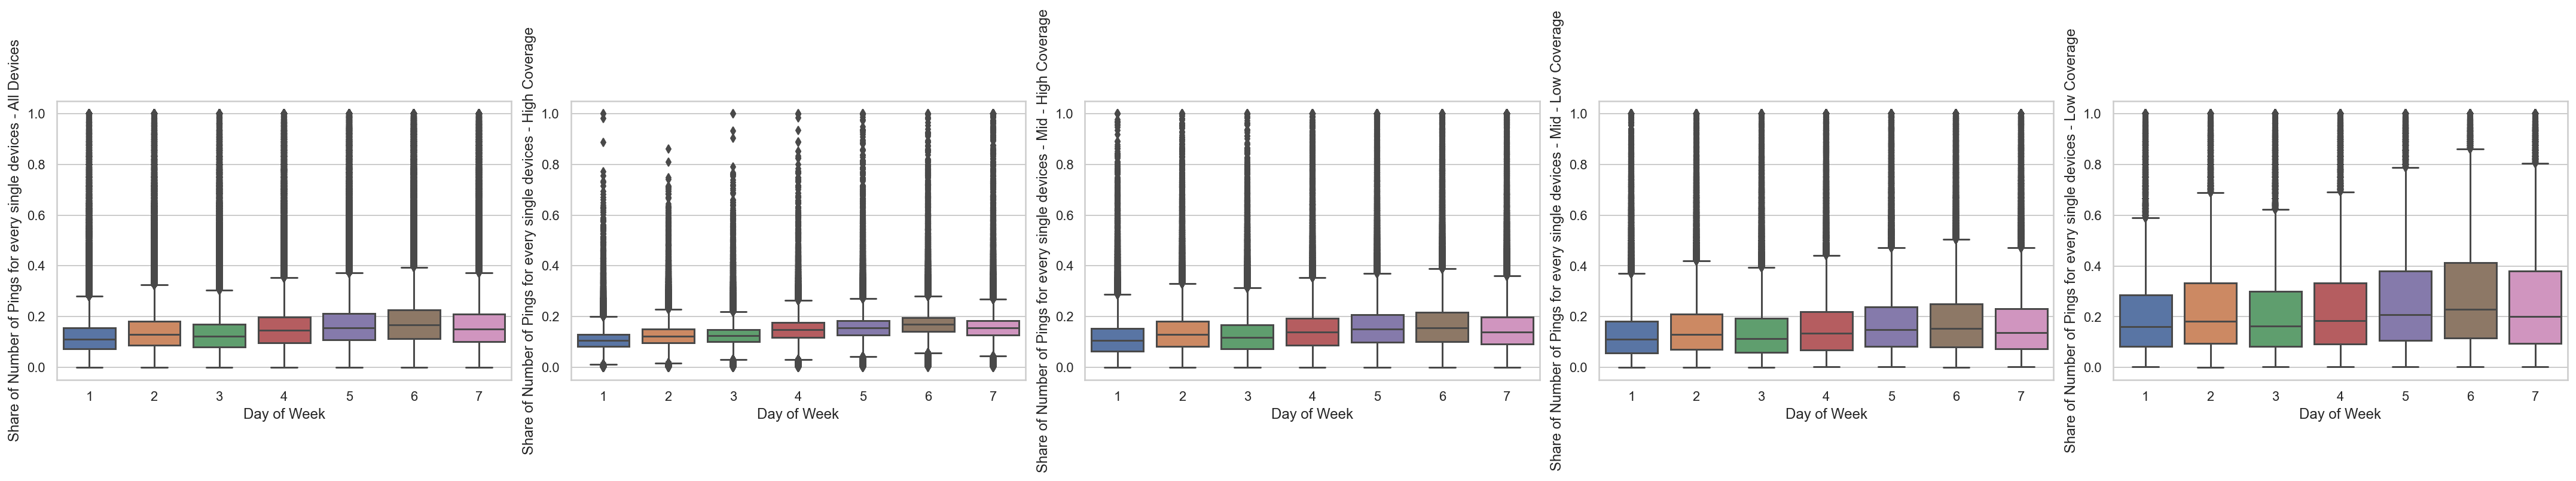

In [46]:
# box plot of share of number of pings for every single devices, aggregate at day of week level
box_plot('df_day_every_device', 'dofw', 'num_pings', 'Day of Week', 'Share of Number of Pings for every single devices')

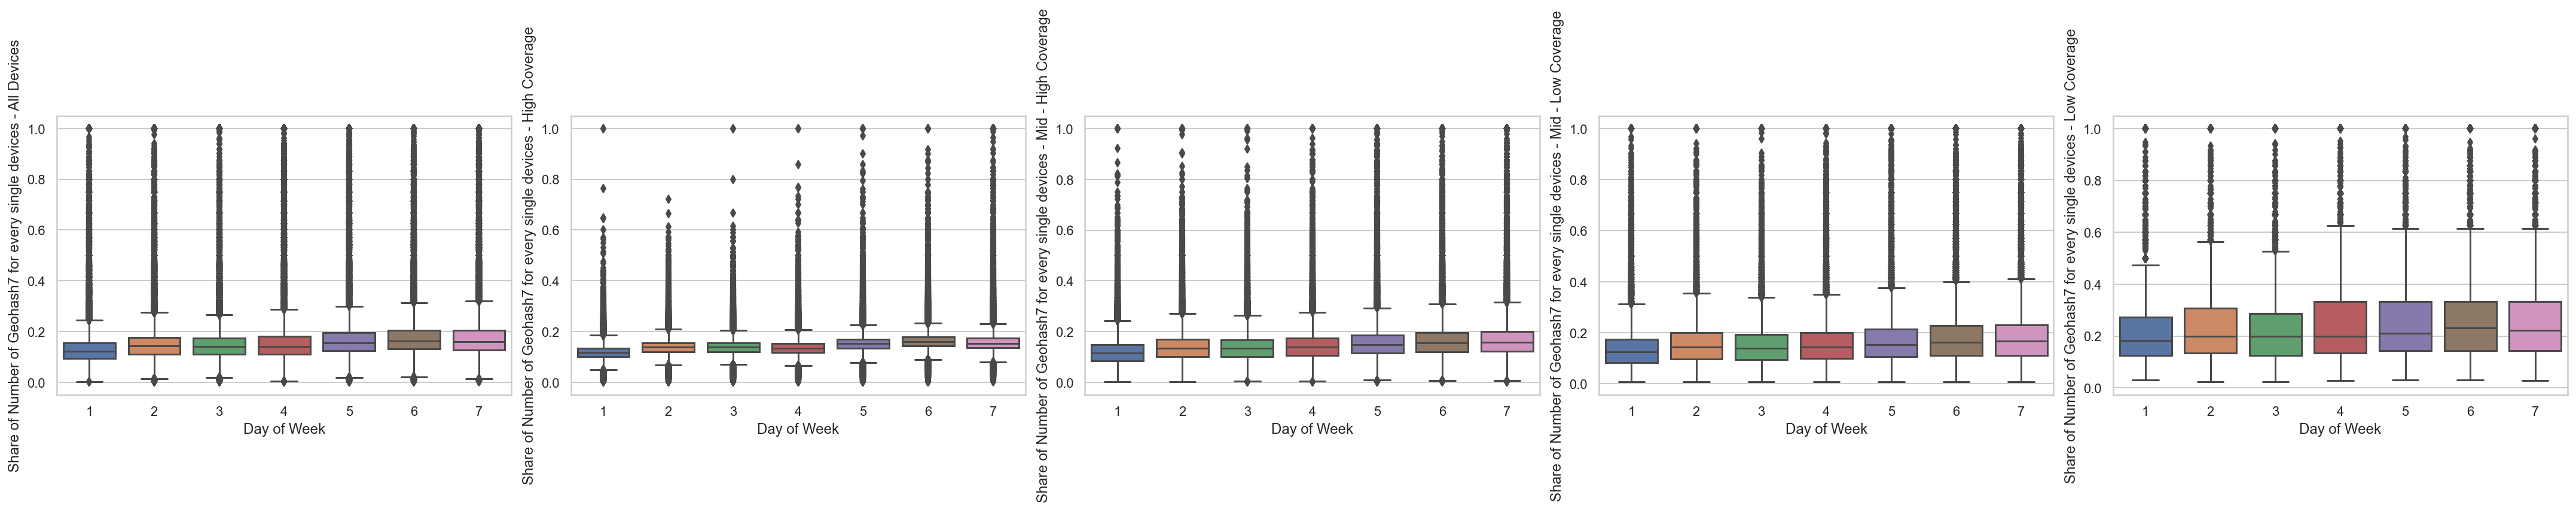

In [47]:
# box plot of share of number of geohash7 for every single devices, aggregate at day of week level
box_plot('df_day_every_device', 'dofw', 'num_geohash7', 'Day of Week', 'Share of Number of Geohash7 for every single devices')

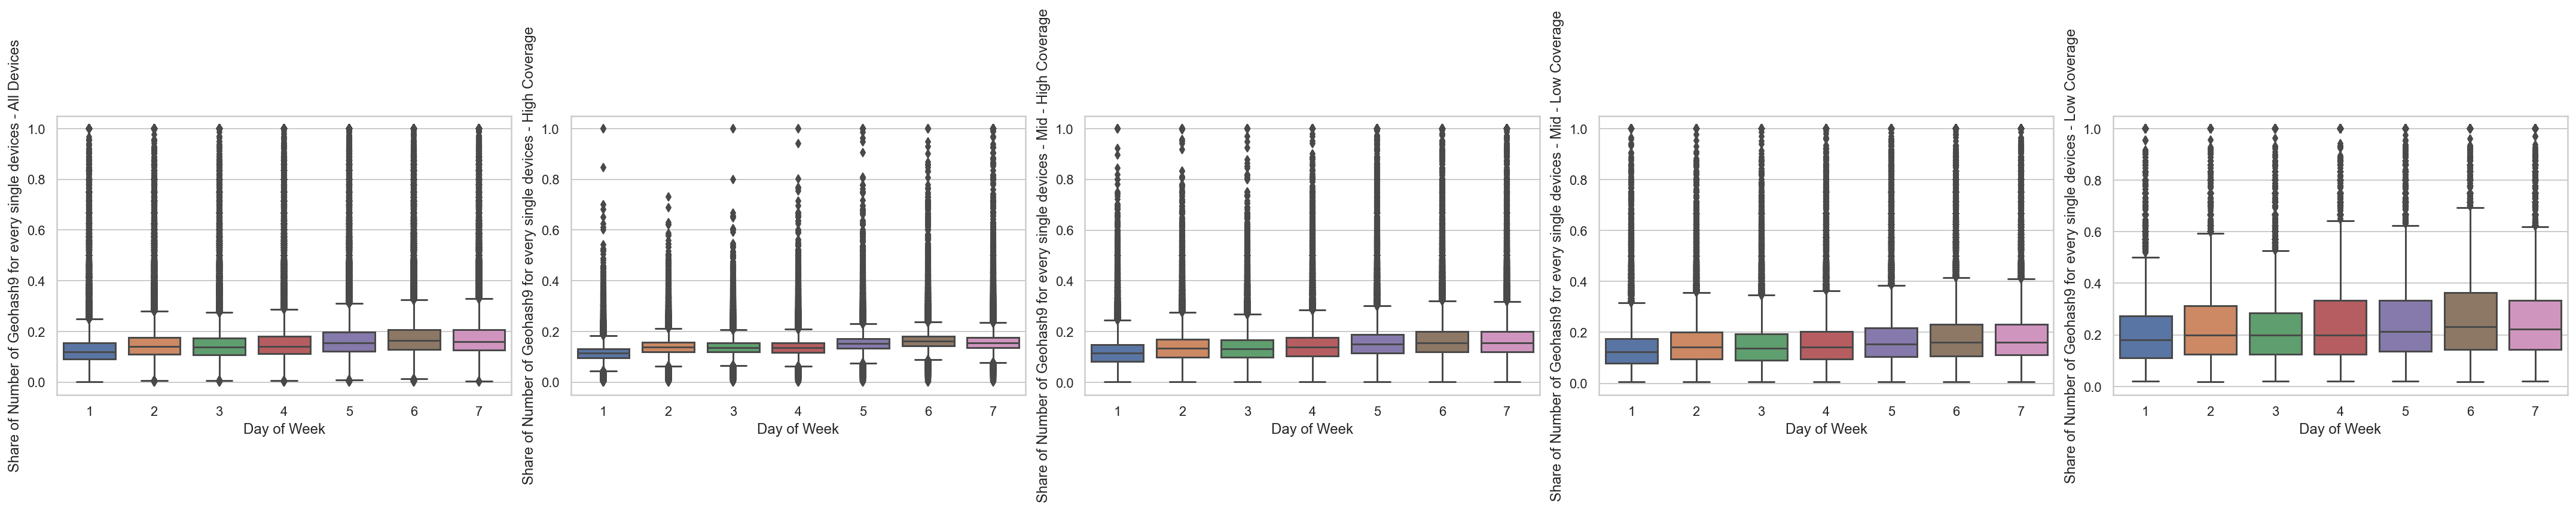

In [48]:
# box plot of share of number of geohash9 for every single devices, aggregate at day of week level
box_plot('df_day_every_device', 'dofw', 'num_geohash9', 'Day of Week', 'Share of Number of Geohash9 for every single devices')